### Image Classification with HOG Feature and SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn import datasets
from mlxtend.data import loadlocal_mnist
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Load image dataset

In [2]:
letter_images, letter_labels = loadlocal_mnist(
    images_path='dataset/emnist-letters-train-images-idx3-ubyte',
    labels_path='dataset/emnist-letters-train-labels-idx1-ubyte'
)

letter_labels = letter_labels - 1  # Adjust labels to be 0-25 for A-Z

In [3]:
len(letter_images) 
len(letter_labels) 

124800

In [4]:
# Misalnya letter_images dan letter_labels adalah array NumPy
selected_images = []
selected_labels = []

for label in range(26):  # karena kelasnya 0 sampai 25
    indices = np.where(letter_labels == label)[0]  # cari index dengan label tertentu
    selected_indices = indices[:100]  # ambil 100 data pertama
    selected_images.append(letter_images[selected_indices])
    selected_labels.append(letter_labels[selected_indices])

# Gabungkan semua hasil jadi satu array
selected_images = np.concatenate(selected_images, axis=0)
selected_labels = np.concatenate(selected_labels, axis=0)

print("Jumlah data akhir:", len(selected_images))  # Harusnya 2600
print("Jumlah data akhir:", len(selected_labels))  # Harusnya 2600

Jumlah data akhir: 2600
Jumlah data akhir: 2600


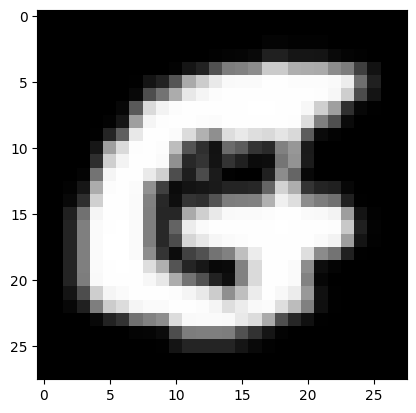

In [5]:
plt.imshow(letter_images[1].reshape(28,28).T, cmap='gray')

In [6]:
letter_labels[1]


np.uint8(6)

In [7]:
# Hitung distribusi label
unique, counts = np.unique(selected_labels, return_counts=True)

# Konversi label angka (0–25) ke huruf (A–Z)
labels_as_letters = [chr(label + 65) for label in unique]  # chr(65) = 'A'

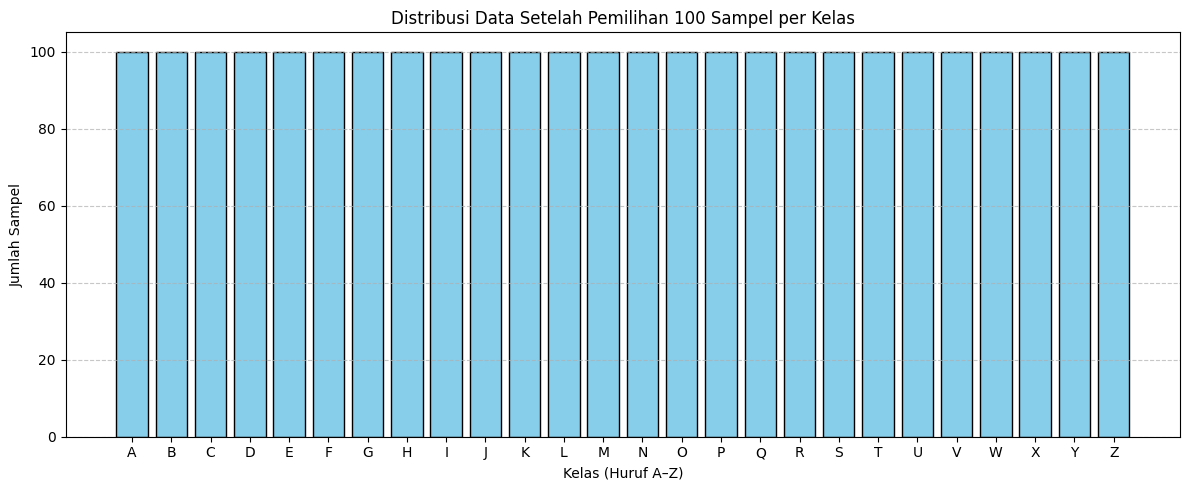

In [8]:
plt.figure(figsize=(12, 5))
plt.bar(labels_as_letters, counts, color='skyblue', edgecolor='black')
plt.title("Distribusi Data Setelah Pemilihan 100 Sampel per Kelas")
plt.xlabel("Kelas (Huruf A–Z)")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.utils import shuffle

# Shuffle sebelum split
selected_images, selected_labels = shuffle(selected_images, selected_labels, random_state=42)


In [10]:

# Split data 80% training dan 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    selected_images,
    selected_labels,
    test_size=0.2,
    stratify=selected_labels,  # penting agar proporsi kelas tetap seimbang
    random_state=42            # untuk hasil yang konsisten
)

print("Jumlah data training:", len(X_train))  # Harusnya 2080
print("Jumlah data testing :", len(X_test))   # Harusnya 520

Jumlah data training: 2080
Jumlah data testing : 520


In [11]:
# Simpan salinan gambar asli untuk visualisasi
X_train_images = X_train.copy()
X_test_images = X_test.copy()

### HOG

In [12]:
# 2. Fungsi ekstraksi HOG
def extract_hog_features(images):
    features = []
    for img in images:
        feat, _ = hog(
            img.reshape(28, 28),
            orientations= 8,
            pixels_per_cell=(4, 4),
            cells_per_block=(2, 2),
            visualize=True,
            block_norm='L2'
        )
        features.append(feat)
    return np.array(features)

# 3. Ekstraksi HOG ke X_train dan X_test
X_train = extract_hog_features(X_train)
X_test = extract_hog_features(X_test)

print("X_train shape:", X_train.shape)  # Harusnya (2080, n_dims)
print("X_test shape:", X_test.shape)    # Harusnya (520, n_dims)


X_train shape: (2080, 1152)
X_test shape: (520, 1152)


In [13]:
print("HOG features shape:", X_train.shape)  # Harusnya (2080, n_dims)
print("HOG features shape:", X_test.shape)  

HOG features shape: (2080, 1152)
HOG features shape: (520, 1152)


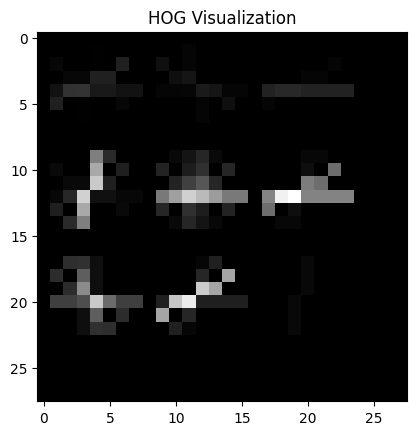

In [14]:
feature, hog_img = hog(selected_images[0].reshape(28, 28), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=True, block_norm='L2')
plt.imshow(hog_img, cmap='gray')
plt.title("HOG Visualization")
plt.show()

### SVC


In [15]:
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    "kernel": ["linear", "rbf"]
}
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=2, n_jobs=-1, scoring="accuracy", verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 2 folds for each of 30 candidates, totalling 60 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.8s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   5.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   6.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   5.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   6.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   2.7s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   3.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   2.7s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   4.9s
[CV] END ...................

=== Evaluasi Model ===
Test Accuracy  : 0.8269
Precision      : 0.8331
Recall         : 0.8269
F1 Score       : 0.8256

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.90      0.78        20
           1       0.95      0.95      0.95        20
           2       0.84      0.80      0.82        20
           3       0.73      0.80      0.76        20
           4       0.81      0.85      0.83        20
           5       1.00      0.70      0.82        20
           6       0.89      0.80      0.84        20
           7       0.85      0.85      0.85        20
           8       0.44      0.35      0.39        20
           9       0.94      0.85      0.89        20
          10       0.89      0.80      0.84        20
          11       0.58      0.70      0.64        20
          12       0.83      0.95      0.88        20
          13       0.82      0.70      0.76        20
          14       0.87      1.00      0.93  

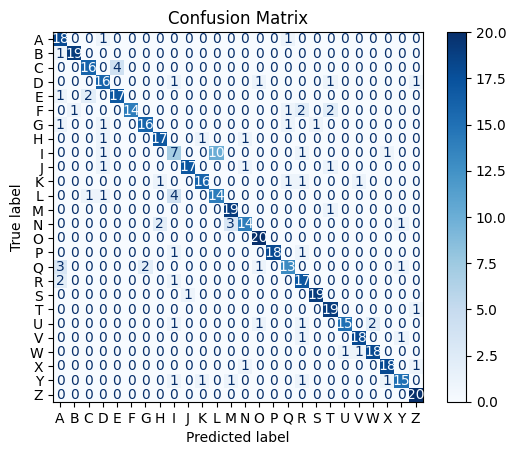

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',  'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# === Prediksi ===
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# === Evaluasi performa model ===
print("=== Evaluasi Model ===")
print(f"Test Accuracy  : {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"F1 Score       : {f1_score(y_test, y_pred_test, average='macro'):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


### Test 20% 

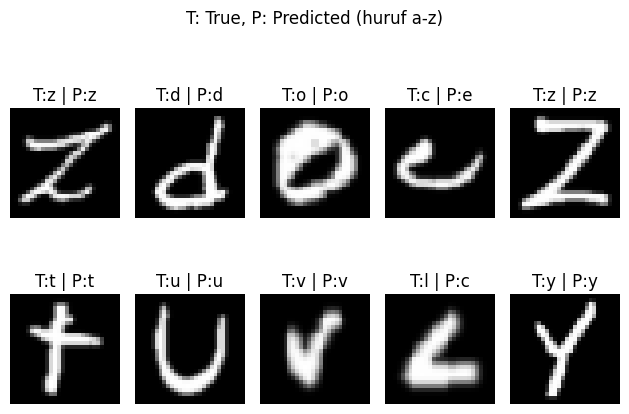

In [17]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(len(X_test_images)), 10)

for i, idx in enumerate(indices):
    img = X_test_images[idx].reshape(28, 28).T # Gambar asli
    true_label = y_test[idx] 
    pred_label = y_pred_test[idx] 

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{chr(true_label + 97)} | P:{chr(pred_label + 97)}") 
    plt.axis('off')

plt.suptitle("T: True, P: Predicted (huruf a-z)")
plt.tight_layout()
plt.show()
